# **Recursive Feature Elimination (RFE) to Predict Customer Churn**

Let's dig down how recursive feature elimination can be useful to reduce data with many features, and this feature-selected data will still give similar performance result (or even higher) on various machine learning models compared to the original data.

## Contents
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
2. [Feature Engineering and Selection](#Feature-Engineering-and-Selection)
3. [Build Some ML Models](#Build-Some-ML-Models)
4. [Model Evaluation](#Model-Evaluation)
5. [Feature Importance](#Feature-Importance)
6. [Summary](#Summary)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
random_state = 123

Import the dataset.

In [2]:
df = pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv", index_col="customerID")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Do some changes on "SeniorCitizen" and "TotalCharges" data type to make them appropriate.

In [3]:
df["TotalCharges"] = df["TotalCharges"].apply(pd.to_numeric, errors='coerce')
df["SeniorCitizen"] = df["SeniorCitizen"].apply(lambda x: "Yes" if x == 0 else "No")

Let's check the data type.

In [4]:
df.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Remove any rows that have NaN value.

In [5]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

<a id='Exploratory-Data-Analysis'></a>
# A. Exploratory Data Analysis

Make histogram for every numeric features against churn.

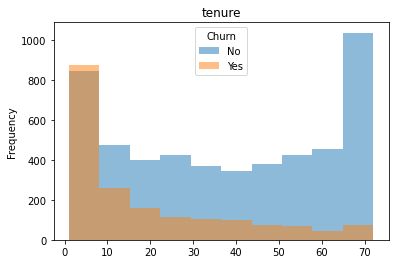

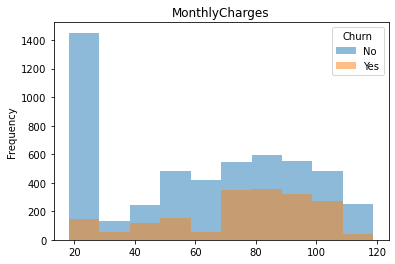

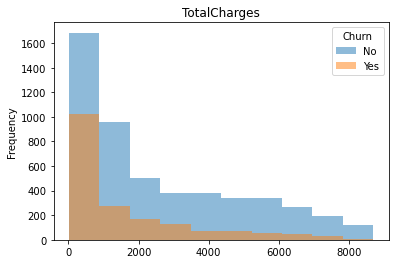

In [8]:
for column in df.select_dtypes("number").columns:
    df.pivot(columns="Churn")[column].plot.hist(alpha=0.5)
    plt.title(column)
    plt.show()

Then, make bar plot for every categorical features against churn.

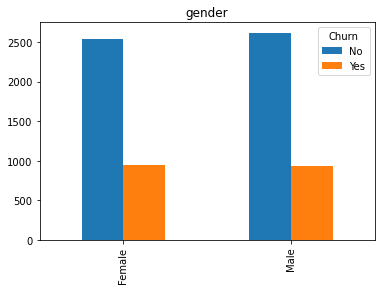

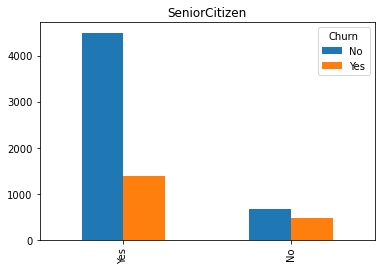

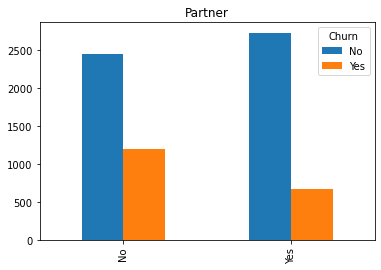

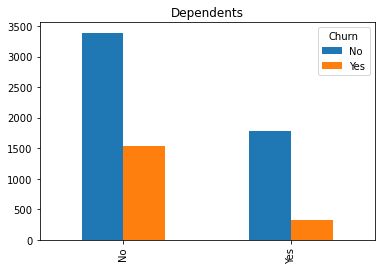

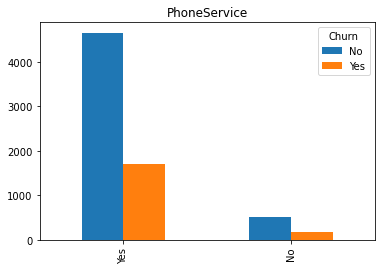

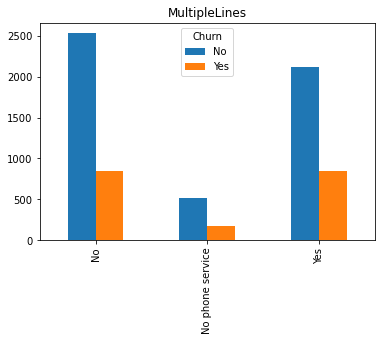

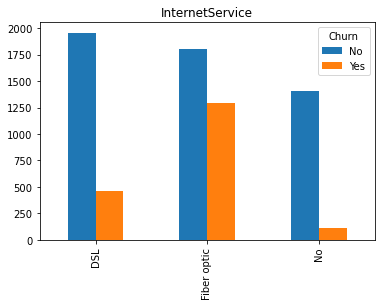

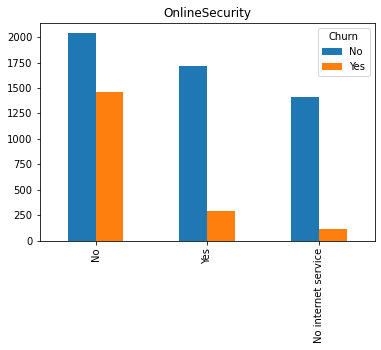

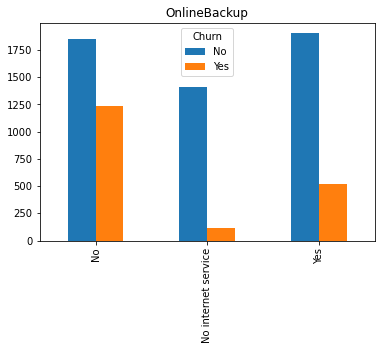

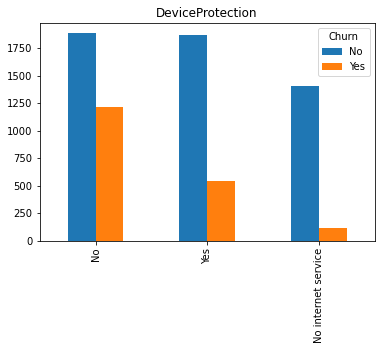

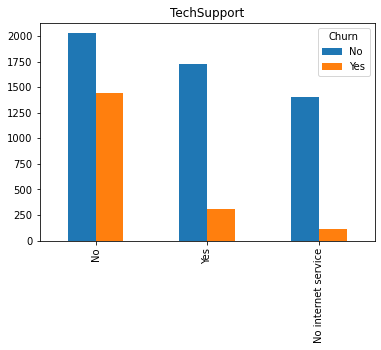

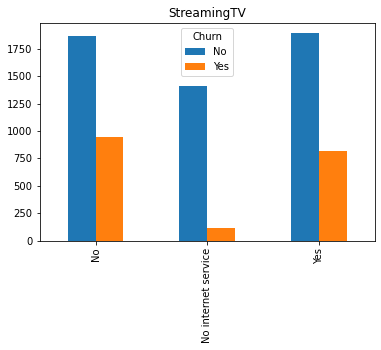

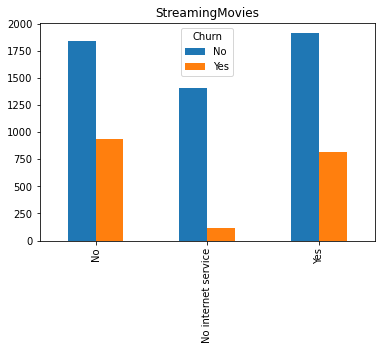

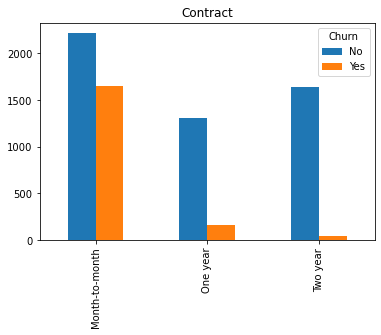

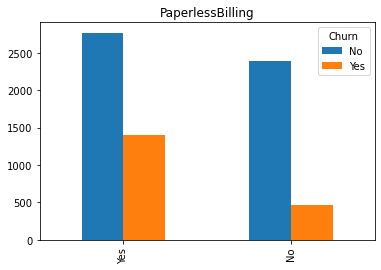

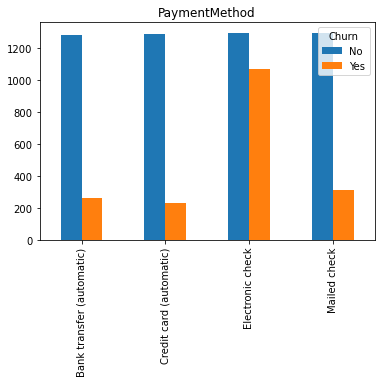

In [9]:
for column in df.select_dtypes("object").columns.drop("Churn"):
    df.pivot(columns="Churn")[column].apply(pd.value_counts).plot.bar()
    plt.title(column)
    plt.show()

<a id='Feature-Engineering-and-Selection'></a>
# B. Feature Engineering and Selection

Separate features and label column into two variables, X and y.

In [10]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

Use StandarScaler to standardize all numerical features, so their mean and standard deviation are zero and one, respectively.

In [11]:
scaler = StandardScaler()
X[X.select_dtypes("number").columns] = scaler.fit_transform(X.select_dtypes("number"))

Encode each categorical feature by using ordinal encoder.

In [12]:
ordEnc = OrdinalEncoder(dtype=np.int)
X[X.select_dtypes("object").columns] = ordEnc.fit_transform(X.select_dtypes("object"))

Also, don't forget to encode the label.

In [13]:
labEnc = LabelEncoder()
y = labEnc.fit_transform(y)

Do feature selection by using recursive feature elimination (RFE). Use Logistic Regression classifier as the estimator, and set the fold (k) for cross-validation to 10.

In [14]:
estimator = LogisticRegression(random_state=random_state)
rfecv = RFECV(estimator=estimator, cv=StratifiedKFold(10, random_state=random_state, shuffle=True), scoring="accuracy")
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
      estimator=LogisticRegression(random_state=123), scoring='accuracy')

Make a line plot of number of selected features against cross-validation score. Then, print the optimal number of features.

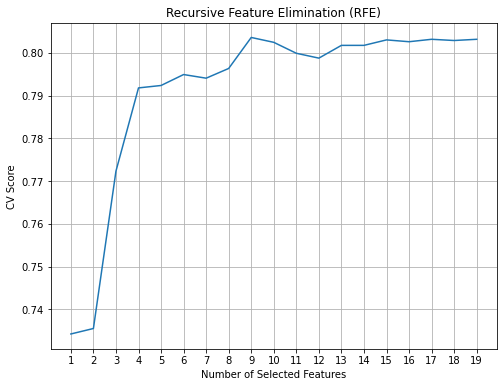

The optimal number of features: 9


In [15]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.grid()
plt.xticks(range(1, X.shape[1]+1))
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()

print("The optimal number of features: {}".format(rfecv.n_features_))

Make a new DataFrame called "X_rfe" that contains selected features.

In [16]:
X_rfe = X.iloc[:, rfecv.support_]

Compare the dimension of DataFrame "X" and "X_rfe".

In [17]:
print("\"X\" dimension: {}".format(X.shape))
print("\"X\" column list:", X.columns.tolist())
print("\"X_rfe\" dimension: {}".format(X_rfe.shape))
print("\"X_rfe\" column list:", X_rfe.columns.tolist())

"X" dimension: (7032, 19)
"X" column list: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
"X_rfe" dimension: (7032, 9)
"X_rfe" column list: ['SeniorCitizen', 'tenure', 'PhoneService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges']


From the steps above, the data is reduced to only 9 features from 19 features in the original data.

Now, let's compare their performance on various machine learning models.

<a id='Build-Some-ML-Models'></a>
# C. Build Some ML Models

Split the feature-selected DataFrame into train and test set. Also, do the same thing on the original DataFrame.

In [18]:
X_train, X_test, X_rfe_train, X_rfe_test, y_train, y_test = train_test_split(X, X_rfe, y, 
                                                                             train_size=0.8, 
                                                                             stratify=y,
                                                                             random_state=random_state)
print("Train size: {}".format(len(y_train)))
print("Test size: {}".format(len(y_test)))

Train size: 5625
Test size: 1407


Let's try these following classifiers to make the machine learning model, and compare their performance for the original and feature-selected dataset.
* Logistic Regression
* Support Vector Machine (linear kernel)
* Naive Bayes
* k-Nearest Neighbors
* Stochastic Gradient Descent
* Decision Tree
* AdaBoost
* Multi-layer Perceptron

In [19]:
clf_keys = ["Logistic Regression", "Support Vector Machine", "Naive Bayes", "k-Nearest Neighbors",
            "Stochastic Gradient Descent", "Decision Tree", "AdaBoost", "Multi-layer Perceptron"]
clf_values = [LogisticRegression(random_state=random_state), SVC(kernel="linear", random_state=random_state),
              GaussianNB(), KNeighborsClassifier(), SGDClassifier(random_state=random_state),
              DecisionTreeClassifier(random_state=random_state), AdaBoostClassifier(random_state=random_state), 
              MLPClassifier(random_state=random_state, max_iter=1000)]
clf_rfe_keys = ["Logistic Regression", "Support Vector Machine", "Naive Bayes", "k-Nearest Neighbors",
                "Stochastic Gradient Descent", "Decision Tree", "AdaBoost", "Multi-layer Perceptron"]
clf_rfe_values = [LogisticRegression(random_state=random_state), SVC(kernel="linear",random_state=random_state),
                  GaussianNB(), KNeighborsClassifier(), SGDClassifier(random_state=random_state),
                  DecisionTreeClassifier(random_state=random_state), AdaBoostClassifier(random_state=random_state), 
                  MLPClassifier(random_state=random_state, max_iter=1000)]
clfs = dict(zip(clf_keys, clf_values))
clfs_rfe = dict(zip(clf_rfe_keys, clf_rfe_values))

# Original dataset
print("Model training using original data: started!")
for clf_name, clf in clfs.items():
    clf.fit(X_train, y_train)
    clfs[clf_name] = clf
    print(clf_name, "training: done!")
print("Model training using original data: done!\n")

# Feature-selected dataset
print("Model training using feature-selected data: started!")
for clf_rfe_name, clf_rfe in clfs_rfe.items():
    clf_rfe.fit(X_rfe_train, y_train)
    clfs_rfe[clf_rfe_name] = clf_rfe
    print(clf_rfe_name, "training: done!")
print("Model training using feature-selected data: done!")

Model training using original data: started!
Logistic Regression training: done!
Support Vector Machine training: done!
Naive Bayes training: done!
k-Nearest Neighbors training: done!
Stochastic Gradient Descent training: done!
Decision Tree training: done!
AdaBoost training: done!
Multi-layer Perceptron training: done!
Model training using original data: done!

Model training using feature-selected data: started!
Logistic Regression training: done!
Support Vector Machine training: done!
Naive Bayes training: done!
k-Nearest Neighbors training: done!
Stochastic Gradient Descent training: done!
Decision Tree training: done!
AdaBoost training: done!
Multi-layer Perceptron training: done!
Model training using feature-selected data: done!


Check the accuracy of these two models, for now.

In [20]:
# Original dataset
acc = []
for clf_name, clf in clfs.items():
    y_pred = clf.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))

# Feature selected dataset
acc_rfe = []
for clf_rfe_name, clf_rfe in clfs_rfe.items():
    y_rfe_pred = clf_rfe.predict(X_rfe_test)
    acc_rfe.append(accuracy_score(y_test, y_rfe_pred))
    
acc_all = pd.DataFrame({"Original dataset": acc, "Feature-selected dataset": acc_rfe},
                       index=clf_keys)
acc_all

,Original dataset,Feature-selected dataset
Logistic Regression,0.792466,0.794598
Support Vector Machine,0.785359,0.796020
Naive Bayes,0.756930,0.755508
k-Nearest Neighbors,0.766880,0.759062
Stochastic Gradient Descent,0.781805,0.773276
Decision Tree,0.715707,0.724236
AdaBoost,0.794598,0.792466
Multi-layer Perceptron,0.768301,0.791045


Make a bar plot of all accuracy results to visualize them.

Accuracy
Original dataset            0.770256
Feature-selected dataset    0.773276


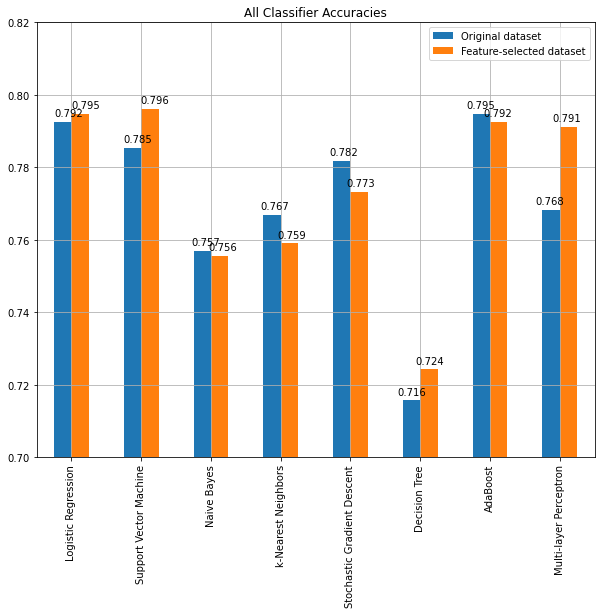

In [21]:
print("Accuracy\n" + acc_all.mean().to_string())

ax = acc_all.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.985, p.get_height()*1.002))
plt.ylim((0.7, 0.82))
plt.xticks(rotation=90)
plt.title("All Classifier Accuracies")
plt.grid()
plt.show()

From the result above, the mean accuracy of feature-selected data is slightly higher (0.3% higher) than the mean accuracy of the original data. The model that has the best accuracy is Support Vector Machine trained on feature-selected data with 79.6% accuracy. Multi-layer Perceptron accuracy improved by 2.3% with training on feature-selected data. But, there are some classifiers (Naive Bayes, k-Nearest Neighbors, Stochastic Gradient Descent, and AdaBoost) that don't get the advantage from training on feature-selected data.

To ensure this result, evaluate the model by using cross-validation.

<a id='Model-Evaluation'></a>
# D. Model Evaluation

To validate the accuracy result and evaluate the performance of these two models furthermore, do k-fold cross-validation with $k = 10$ on the whole dataset.
Metrics to validate are: accuracy, and ROC AUC score.

In [22]:
scoring = ["accuracy", "roc_auc"]

scores = []
# Original dataset
print("Cross-validation on original data: started!")
for clf_name, clf in clfs.items():
    score = pd.DataFrame(cross_validate(clf, X, y, cv=StratifiedKFold(10, random_state=random_state, shuffle=True), scoring=scoring)).mean()
    scores.append(score)
    print(clf_name, "cross-validation: done!")
cv_scores = pd.concat(scores, axis=1).rename(columns=dict(zip(range(len(clf_keys)), clf_keys)))
print("Cross-validation on original data: done!\n")

scores = []
# Feature-selected dataset
print("Cross-validation on feature-selected data: started!")
for clf_name, clf in clfs_rfe.items():
    score = pd.DataFrame(cross_validate(clf, X_rfe, y, cv=StratifiedKFold(10, random_state=random_state, shuffle=True), scoring=scoring)).mean()
    scores.append(score)
    print(clf_name, "cross-validation: done!")
cv_scores_rfe = pd.concat(scores, axis=1).rename(columns=dict(zip(range(len(clf_keys)), clf_keys)))
print("Cross-validation on feature-selected data: done!")

Cross-validation on original data: started!
Logistic Regression cross-validation: done!
Support Vector Machine cross-validation: done!
Naive Bayes cross-validation: done!
k-Nearest Neighbors cross-validation: done!
Stochastic Gradient Descent cross-validation: done!
Decision Tree cross-validation: done!
AdaBoost cross-validation: done!
Multi-layer Perceptron cross-validation: done!
Cross-validation on original data: done!

Cross-validation on feature-selected data: started!
Logistic Regression cross-validation: done!
Support Vector Machine cross-validation: done!
Naive Bayes cross-validation: done!
k-Nearest Neighbors cross-validation: done!
Stochastic Gradient Descent cross-validation: done!
Decision Tree cross-validation: done!
AdaBoost cross-validation: done!
Multi-layer Perceptron cross-validation: done!
Cross-validation on feature-selected data: done!


Let's visualize cross-validation accuracy, ROC AUC score, and fit time results.

Cross-validation accuracy
Original data            0.774493
Feature-selected data    0.782513


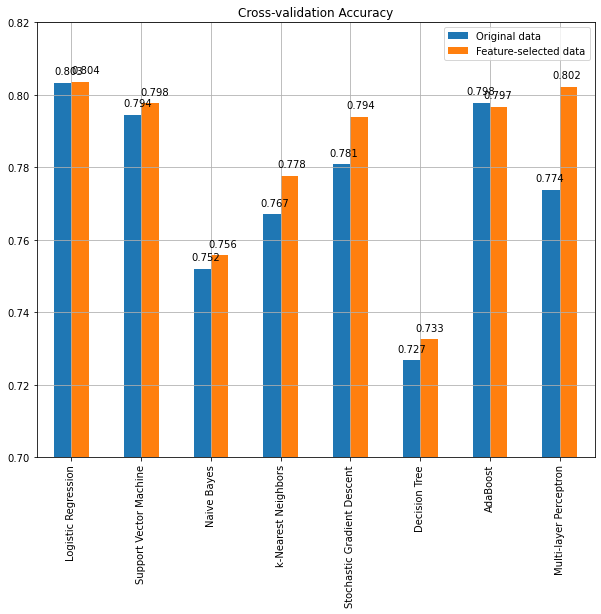

In [23]:
# Accuracy
cv_acc_all = pd.concat([cv_scores.loc["test_accuracy"].rename("Original data"), cv_scores_rfe.loc["test_accuracy"].rename("Feature-selected data")], 
                       axis=1)

print("Cross-validation accuracy\n" + cv_acc_all.mean().to_string())
ax = cv_acc_all.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.985, p.get_height()*1.003))
plt.xticks(rotation=90)
plt.ylim((0.7, 0.82))
plt.title("Cross-validation Accuracy")
plt.grid()
plt.legend()
plt.show()

Cross-validation ROC AUC score
Original data            0.800011
Feature-selected data    0.808924


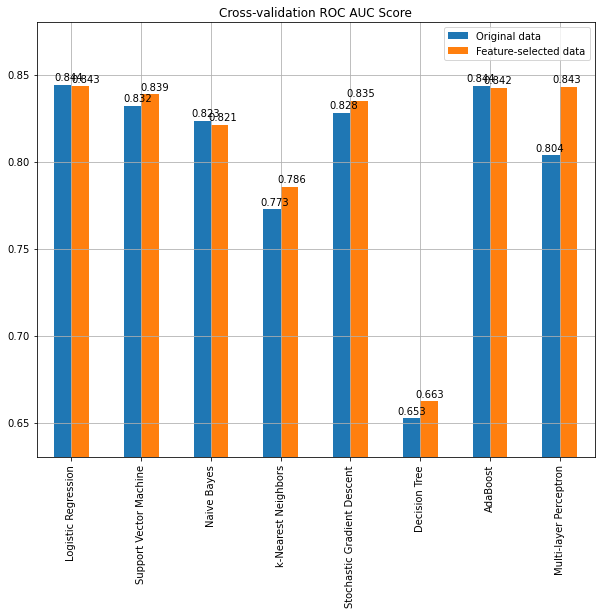

In [24]:
# ROC AUC
cv_roc_auc_all = pd.concat([cv_scores.loc["test_roc_auc"].rename("Original data"), cv_scores_rfe.loc["test_roc_auc"].rename("Feature-selected data")], 
                           axis=1)

print("Cross-validation ROC AUC score\n" + cv_roc_auc_all.mean().to_string())
ax = cv_roc_auc_all.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.985, p.get_height()*1.003))
plt.xticks(rotation=90)
plt.ylim((0.63, 0.88))
plt.title("Cross-validation ROC AUC Score")
plt.grid()
plt.legend()
plt.show()

Cross-validation fit time
Original data            2.812444
Feature-selected data    0.964001


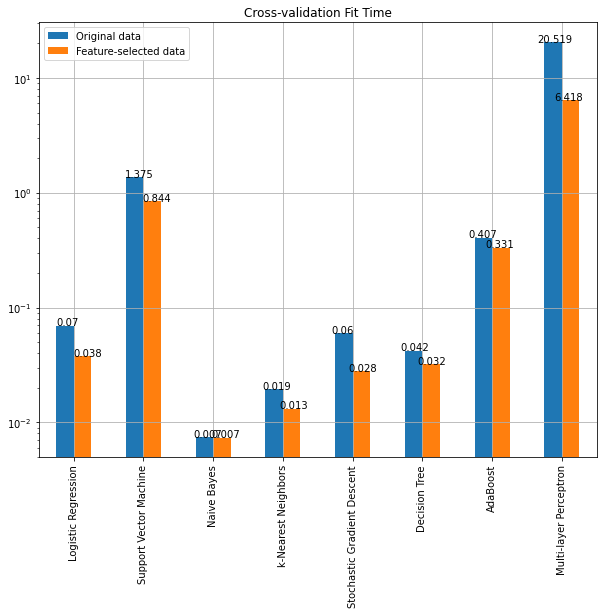

In [25]:
# Fit time
cv_fit_time_all = pd.concat([cv_scores.loc["fit_time"].rename("Original data"), cv_scores_rfe.loc["fit_time"].rename("Feature-selected data")], 
                           axis=1)

print("Cross-validation fit time\n" + cv_fit_time_all.mean().to_string())
ax = cv_fit_time_all.plot.bar(figsize=(10, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x()*0.985, p.get_height()*1.003))
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Cross-validation Fit Time")
plt.grid()
plt.legend()
plt.show()

From the accuracy result, the mean accuracy of feature-selected data is 0.75% higher than the mean accuracy of the original data. The best accuracy here is Logistic Regression model trained on feature-selected data with 80.4% accuracy. Multi-layer Perceptron accuracy got the highest improvement by 2.8% with training on feature-selected data. Both SVM and AdaBoost accuracies of feature-selected data are slightly lower (only 0.1% lower) than the accuracies of original data. Remember, feature-selected data only has **9 features** while original data has 19 features.

The models that have the best ROC AUC score are Logistic Regression and AdaBoost with an ROC AUC score of 0.844. The ROC AUC result is not much different from the accuracy result. But there are some classifiers (Logistic Regression, Naive Bayes, and AdaBoost) that have slightly lower ROC AUC score of feature-selected data than the ROC AUC score of original data.

All models that were trained on feature-selected data have faster fit time than the one that was trained on original data. It is obviously because the number of features trained on those models.

<a id='Feature-Importance'></a>
# E. Feature Importance

Find the feature importance of the predictive model that has been made. In this case, use Logistic Regression because it has the highest accuracy among all models.

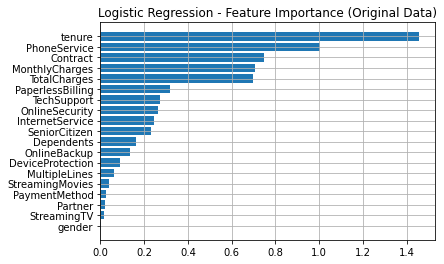

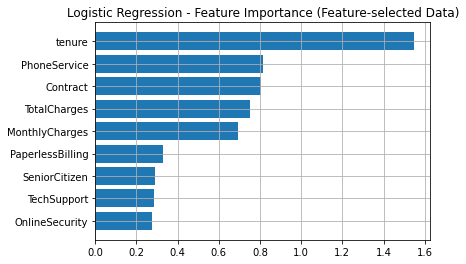

In [26]:
importance = abs(clfs["Logistic Regression"].coef_[0])
plt.barh(X.columns.values[importance.argsort()], importance[importance.argsort()])
plt.title("Logistic Regression - Feature Importance (Original Data)")
plt.grid()
plt.show()

importance_rfe = abs(clfs_rfe["Logistic Regression"].coef_[0])
plt.barh(X_rfe.columns.values[importance_rfe.argsort()], importance_rfe[importance_rfe.argsort()])
plt.title("Logistic Regression - Feature Importance (Feature-selected Data)")
plt.grid()
plt.show()

Top 5 important features of both Logistic Regression models are the same ("tenure", "PhoneService", "Contract", "TotalCharges", and "MonthlyCharges"). The rest of these important features are quite the same in both models.

Let's check the feature importance of AdaBoost classifier for comparison.

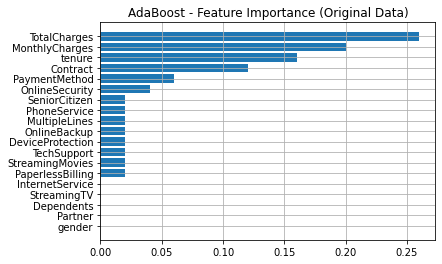

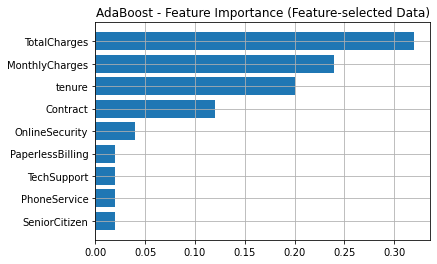

In [27]:
importance = clfs["AdaBoost"].feature_importances_
plt.barh(X.columns.values[importance.argsort()], importance[importance.argsort()])
plt.title("AdaBoost - Feature Importance (Original Data)")
plt.grid()
plt.show()

importance_rfe = clfs_rfe["AdaBoost"].feature_importances_
plt.barh(X_rfe.columns.values[importance_rfe.argsort()], importance_rfe[importance_rfe.argsort()])
plt.title("AdaBoost - Feature Importance (Feature-selected Data)")
plt.grid()
plt.show()

The top 5 important features of both AdaBoost models are slightly different. AdaBoost classifier that was trained on original data includes "PaymentMethod" on the fifth rank of its feature importance, while this feature is not selected during the RFE step. The rest of these important features are similar in both models.

Also find the feature importance of Support Vector Machine.

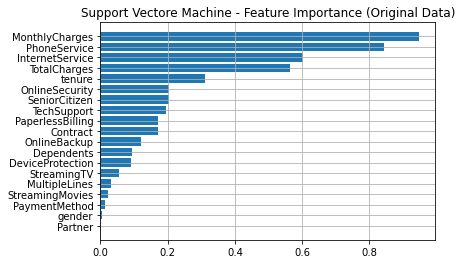

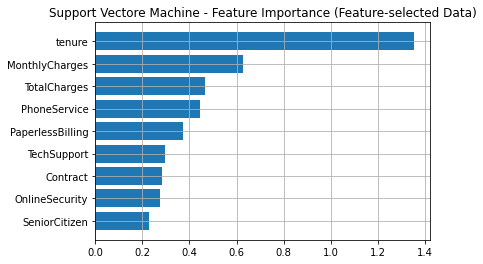

In [28]:
importance = abs(clfs["Support Vector Machine"].coef_[0])
plt.barh(X.columns.values[importance.argsort()], importance[importance.argsort()])
plt.title("Support Vectore Machine - Feature Importance (Original Data)")
plt.grid()
plt.show()

importance_rfe = abs(clfs_rfe["Support Vector Machine"].coef_[0])
plt.barh(X_rfe.columns.values[importance_rfe.argsort()], importance_rfe[importance_rfe.argsort()])
plt.title("Support Vectore Machine - Feature Importance (Feature-selected Data)")
plt.grid()
plt.show()

The top 5 important features of both Support Vector Machine models are kind of different. SVM classifier that was trained on original data placed "tenure" on the fifth rank, while the other model placed "tenure" on the first rank.

From these three models, "tenure", "MonthlyCharges", and "TotalCharges" are always appeared on the top 5 important features of each model.

<a id='Summary'></a>
# F. Summary

Recursive feature elimination (RFE) is very useful to select only necessary features, save the training time, and still get similar accuracy, or even higher than the original data. RFE is popular because it is easy to configure and use and because it is effective at selecting those features (columns) in a training dataset that are more or most relevant in predicting the target variable. The feature importance of feature-selected data is also still preserved and is quite the same with original data based on the observation above.